In [2]:
import numpy as np
import scipy
import scipy.signal as sig
import scipy.io.wavfile as wav

import matplotlib.pyplot as plt

## 1. TFCT


### 1.1 Généralités


#### a) 

$$
\begin{aligned}
\tilde{X_0}(b, f_0) &= \sum_{n \in \Z} x(n)w(n - b)e^{-2j\pi f_0 n}
\\
&= \left (y_{f_0} * w_- \right)(b)
\\
\end{aligned}
$$
Où :
$$
\begin{aligned}
y_{f_0}(n) &= x(n)e^{-2j\pi f_0 n}
\\
w_-(n) &= w(-n)
\end{aligned}
$$
La fenêtre va opérer un filtrage passe-bas dont la fréquence de coupure
est dictée par sa longueur.

#### b)

On peut écrire :
$$
\begin{aligned}
\tilde{X_{loc}}(b, f_0) &= \sum_{n \in \Z} x(n + b)w(n)e^{-2j\pi f_0 n}
\\
&= \sum_{n \in \Z} x(n)w(n - b)e^{-2j\pi f_0 (n - b)}
\\ 
&= \left ( x * h_{f_0} \right)(b)
\\
&= e^{2j\pi f_0 b} \tilde{X_0}(b, f_0)
\end{aligned}
$$
Où :
$$
\begin{aligned}
h_{f_0}(n) &= w(-n) e^{-2j\pi f_0 n}
\end{aligned}
$$

La fenêtre va opérer un filtrage passe-bande centré sur $f_0$.
La convention utilisée dans `tftc.m` est la convention passe-bande, 
car on écrit la TFTC du signal en $b$ en utilisant seulement les 
échantillons précédents de $x$.

#### c)

In [3]:

audio_dir = "../donnees"
audio_name = 'salsa.wav' 

audio_file = os.path.join(audio_dir, audio_name)
sr, s = wav.read(audio_file)
if s.ndim == 2:
    s = s[:, 0]

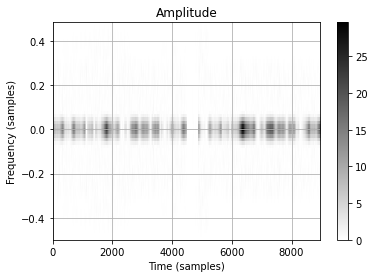

In [4]:
def stft(x: np.ndarray, w: np.ndarray, n: int, r: int) -> np.ndarray:
    m = w.shape[0]
    assert(m < n)
    nb_frames = (x.shape[0] - m) // r
    #
    x_loc  = np.empty((nb_frames, n), dtype=np.complex128)
    frame_starts = np.arange(nb_frames)*r
    w_norm = w / (2 * np.sum(w))
    for p in np.arange(nb_frames):
        frame_start = frame_starts[p]
        frame_stop = frame_start + m
        x_w = x[frame_start:frame_stop] * w_norm
        x_loc[p] = np.fft.fft(x_w, n=n)
    times = frame_starts
    freqs = np.fft.fftfreq(n=n)
    return x_loc, times, freqs

def plot_stft(x_loc: np.ndarray, times: np.ndarray, freqs: np.ndarray) -> None:
    f = np.fft.fftshift(freqs)
    x_ft_plot = np.fft.fftshift(x_loc).T
    plt.figure()
    plt.title('Amplitude')
    plt.imshow(np.abs(x_ft_plot), origin='lower', aspect='auto', 
        extent=[times[0], times[-1], f[0], f[-1]],
        interpolation='nearest')
    plt.colorbar()
    plt.set_cmap('gray_r')
    plt.xlabel('Time (samples)')
    plt.ylabel('Frequency (samples)')
    plt.grid(True)

n = 64
m = 32
r = 1

t_start = 1000
t_stop = 10000

w = sig.windows.blackman(m)
x_loc, times, freqs = stft(s[t_start:t_stop], w, n, r)
plot_stft(x_loc, times, freqs)

$x_k(p)$ est complexe. 

In [9]:
def stft_too(x: np.ndarray, w: np.ndarray, n: int, r: int, k: int) -> np.ndarray:
    m = w.shape[0]
    assert(m < n)
    assert(k < n)
    nb_frames = (s.shape[0] - m) // r
    #
    x_loc_k = np.zeros((nb_frames), dtype=np.complex128)
    #
    frame_starts = np.arange(nb_frames)*r
    y_f = x * np.exp(2j * np.pi * k / n * np.arange(x.shape[0]))
    w_minus = w[::-1]
    for p in np.arange(nb_frames):
        frame_start = frame_starts[p]
        frame_stop = frame_start + m
        # print(y_f.shape, w_minus.shape)
        x_loc_k[p] = sig.lfilter(w_minus, [1], y_f[frame_start:frame_stop])
    #
    times = np.arange(nb_frames)*r
    freq = k / n
    return x_loc, times, freq

n = 64
m = 32

r = 1
k = 12

t_start = 1000
t_stop = 10000

w = sig.windows.blackman(m)
x_loc, times, freq = stft_too(s[t_start:t_stop], w, n, r, k)

TypeError: only length-1 arrays can be converted to Python scalars

retur